# Chapter 5: Maintaining your Delta Lake
> The following exercises use the New York Times [Covid-19 NYT Dataset](https://github.com/delta-io/delta-docs/tree/main/static/quickstart_docker/rs/data/COVID-19_NYT).

The dataset can be found in the `delta_quickstart` docker.

In [5]:
from pyspark.sql.types import DateType
from pyspark.sql.functions import col, desc, to_date
from delta.tables import DeltaTable

In [6]:
spark.sql("""
CREATE TABLE IF NOT EXISTS default.covid_nyt (
  date DATE
) USING DELTA
TBLPROPERTIES('delta.logRetentionDuration'='interval 7 days');
""")


24/11/27 07:20:11 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
24/11/27 07:20:11 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
24/11/27 07:20:14 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
24/11/27 07:20:14 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.18.0.2


DataFrame[]

In [7]:
spark.sql("show tables").show()

24/11/27 07:20:14 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
+---------+--------------------+-----------+
|namespace|           tableName|isTemporary|
+---------+--------------------+-----------+
|  default|           covid_nyt|      false|
|  default|   covid_nyt_by_date|      false|
|  default|nonoptimal_covid_nyt|      false|
|  default|            nyc_taxi|      false|
+---------+--------------------+-----------+



In [8]:
# will be empty on the first run. this is expected
len(spark.table("default.covid_nyt").inputFiles())

24/11/27 07:20:19 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


24

In [9]:
# uncomment if you'd like to begin again
#spark.sql("drop table default.covid_nyt")

## Start Populating the Table
> The next three commands are used to show Schema Evolution and Validation with Delta Lake

In [11]:
# Populate the Table reading the Parquet covid_nyc Data
# note: this will fail on the first run, and that is okay
(spark.read
      .format("parquet")
      .load("/opt/spark/work-dir/rs/data/COVID-19_NYT/*.parquet")
      .withColumn("date", to_date("date", "yyyy-MM-dd"))
      .write
      .format("delta")
      .saveAsTable("default.covid_nyt"))

AnalysisException: Table default.covid_nyt already exists

In [12]:
# one step closer, there is still something missing...
# and yes, this operation still fails... if only...
(spark.read
      .format("parquet")
      .load("/opt/spark/work-dir/rs/data/COVID-19_NYT/*.parquet")
      .withColumn("date", to_date("date", "yyyy-MM-dd"))
      .write
      .format("delta")
      .mode("append")
      .saveAsTable("default.covid_nyt"))

24/11/27 07:20:42 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


## Schema Evolution: Handle Automatically
If you trust the upstream data source (provider) then you can add the `option("mergeSchema", "true")`. Otherwise, it is better to specifically select a subset of the columns you expected to see. In this example use case, the only known column is `date`, so it is fairly safe to power ahead.

In [13]:
# Evolve the Schema. (Showcases how to auto-merge changes to the schema)
# note: if you can trust the upstream, then this option is perfectly fine
# however, if you don't trust the upstream, then it is good to opt-in to the 
# changing columns.

(spark.read
      .format("parquet")
      .load("/opt/spark/work-dir/rs/data/COVID-19_NYT/*.parquet")
      .withColumn("date", to_date("date", "yyyy-MM-dd"))
      .write
      .format("delta")
      .mode("append")
      .option("mergeSchema", "true")
      .saveAsTable("default.covid_nyt")
    )

24/11/27 07:20:48 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


In [14]:
df = spark.table("default.covid_nyt")
df.count()

5559650

# Alternatives to Auto Schema Evolution
In the previous case, we used `.option("mergeSchema", "true")` to modify the behavior of the Delta Lake writer. While this option simplifies how we evolve our Delta Lake table schemas, it comes at the price of not being fully aware of the changes to our table schema. In the case where there are unknown columns being introduced from an upstream source, you'll want to know which columns are intended to bring forward, and which columns can be safely ignored.

## Intentionally Adding Columns with Alter Table

In [15]:
# manually set the columns. This is an example of intentional opt-in to the new columns outside of '.option("mergeSchema", "true")`. 
# Note: this can be run once, afterwards the ADD columns will fail since they already exist
spark.sql("""
ALTER TABLE default.covid_nyt 
ADD columns (
  county STRING,
  state STRING,
  fips INT,
  cases INT,
  deaths INT
);
""")
# notice how we are only using `.mode("append")` and explicitly add `.option("mergeSchema", "false")`. 
# this is how we stop unwanted columns from being freely added to our Delta Lake tables. It comes at the cost of raising exceptions and failing the job.
# a failed job might seem like a bad option, but it is the cheaper option since you are intentionally blocking unknown data from flowing into your tables. 
(spark.read
      .format("parquet")
      .load("/opt/spark/work-dir/rs/data/COVID-19_NYT/*.parquet")
      .withColumn("date", to_date("date", "yyyy-MM-dd"))
      .write
      .format("delta")
      .option("mergeSchema", "false")
      .mode("append")
      .saveAsTable("default.covid_nyt"))

AnalysisException: Cannot add column, because county already exists in root
 |-- date: date (nullable = true)
 |-- county: string (nullable = true)
 |-- state: string (nullable = true)
 |-- fips: integer (nullable = true)
 |-- cases: integer (nullable = true)
 |-- deaths: integer (nullable = true)
; line 2 pos 0;
AddColumns [QualifiedColType(None,county,StringType,true,None,None), QualifiedColType(None,state,StringType,true,None,None), QualifiedColType(None,fips,IntegerType,true,None,None), QualifiedColType(None,cases,IntegerType,true,None,None), QualifiedColType(None,deaths,IntegerType,true,None,None)]
+- ResolvedTable org.apache.spark.sql.delta.catalog.DeltaCatalog@a8dd4b7, default.covid_nyt, DeltaTableV2(org.apache.spark.sql.SparkSession@55f6dadf,file:/opt/spark/work-dir/ch5/spark-warehouse/covid_nyt,Some(CatalogTable(
Database: default
Table: covid_nyt
Owner: NBuser
Created Time: Thu Nov 21 05:55:16 UTC 2024
Last Access: UNKNOWN
Created By: Spark 3.3.2
Type: MANAGED
Provider: delta
Location: file:/opt/spark/work-dir/ch5/spark-warehouse/covid_nyt
Serde Library: org.apache.hadoop.hive.serde2.lazy.LazySimpleSerDe
InputFormat: org.apache.hadoop.mapred.SequenceFileInputFormat
OutputFormat: org.apache.hadoop.hive.ql.io.HiveSequenceFileOutputFormat)),Some(default.covid_nyt),None,Map(),org.apache.spark.sql.util.CaseInsensitiveStringMap@1f), [date#2466, county#2467, state#2468, fips#2469, cases#2470, deaths#2471]


In [16]:
spark.sql("describe extended default.covid_nyt").show(truncate=False)

+----------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|col_name                    |data_type                                                                                                                                                                                                                                                                                                    |comment|
+----------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [17]:
spark.sql("select * from default.covid_nyt limit 10").show(truncate=True)

+----------+----------------+---------+-----+-----+------+
|      date|          county|    state| fips|cases|deaths|
+----------+----------------+---------+-----+-----+------+
|2021-02-25|           Caddo|Louisiana|22017|24637|   672|
|2021-02-25|       Calcasieu|Louisiana|22019|19181|   354|
|2021-02-25|        Caldwell|Louisiana|22021| 1076|    25|
|2021-02-25|         Cameron|Louisiana|22023|  543|     5|
|2021-02-25|       Catahoula|Louisiana|22025| 1053|    34|
|2021-02-25|       Claiborne|Louisiana|22027| 1407|    49|
|2021-02-25|       Concordia|Louisiana|22029| 1770|    55|
|2021-02-25|         De Soto|Louisiana|22031| 2635|    71|
|2021-02-25|East Baton Rouge|Louisiana|22033|35389|   732|
|2021-02-25|    East Carroll|Louisiana|22035| 1094|    23|
+----------+----------------+---------+-----+-----+------+



# Adding and Modifying Table Properties

In [18]:
spark.sql("""
  ALTER TABLE default.covid_nyt 
  SET TBLPROPERTIES (
    'catalog.team_name'='dldg_authors',
    'catalog.engineering.comms.slack'='https://delta-users.slack.com/archives/CG9LR6LN4',
    'catalog.engineering.comms.email'='dldg_authors@gmail.com',
    'catalog.table.classification'='all-access'
  )""")


DataFrame[]

In [19]:
# view the table history
from delta.tables import DeltaTable
dt = DeltaTable.forName(spark, 'default.covid_nyt')
dt.history(10).select("version", "timestamp", "operation").show()

+-------+--------------------+--------------------+
|version|           timestamp|           operation|
+-------+--------------------+--------------------+
|     30|2024-11-27 07:20:...|   SET TBLPROPERTIES|
|     29|2024-11-27 07:20:...|               WRITE|
|     28|2024-11-27 07:20:...|               WRITE|
|     27|2024-11-27 07:04:...| UNSET TBLPROPERTIES|
|     26|2024-11-27 07:04:...|   SET TBLPROPERTIES|
|     25|2024-11-27 07:04:...|   SET TBLPROPERTIES|
|     24|2024-11-27 07:04:...|               WRITE|
|     23|2024-11-27 07:04:...|               WRITE|
|     22|2024-11-27 05:31:...|CREATE OR REPLACE...|
|     21|2024-11-27 05:30:...|               WRITE|
+-------+--------------------+--------------------+



In [20]:
# use DeltaTable to view
dt.detail().select("properties").show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|properties                                                                                                                                                                                                                                                                    |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|{catalog.table.classification -> all-access, catalog.engineering.comms.email -> dldg_authors@gmail.com, delta.logRetentionDuration -> interval 7 days, catalog.team_name -> dldg_aut

In [21]:
# view the table properties
spark.sql("show tblproperties default.covid_nyt").show(truncate=False)

+-------------------------------+------------------------------------------------+
|key                            |value                                           |
+-------------------------------+------------------------------------------------+
|catalog.engineering.comms.email|dldg_authors@gmail.com                          |
|catalog.engineering.comms.slack|https://delta-users.slack.com/archives/CG9LR6LN4|
|catalog.table.classification   |all-access                                      |
|catalog.team_name              |dldg_authors                                    |
|delta.logRetentionDuration     |interval 7 days                                 |
|delta.minReaderVersion         |1                                               |
|delta.minWriterVersion         |2                                               |
+-------------------------------+------------------------------------------------+



## Removing Table Properties

In [22]:
# add incorrect table property
# which is blocked by default
spark.conf.set("spark.databricks.delta.allowArbitraryProperties.enabled","true")
# now we can make a mistake
spark.sql("""
  ALTER TABLE default.covid_nyt 
  SET TBLPROPERTIES (
    'delta.loRgetentionDuratio'='interval 7 days'
  )""")

You are setting a property: delta.loRgetentionDuratio that is not recognized by this version of Delta


DataFrame[]

In [23]:
# luckily, we can remove the unwanted table property using UNSET
spark.sql("""
  ALTER TABLE default.covid_nyt 
  UNSET TBLPROPERTIES ('delta.loRgetentionDuratio')
""")
# now that we are done, let's just add back the safe guard again
spark.conf.set("spark.databricks.delta.allowArbitraryProperties.enabled","false")

## Delta Table Optimization

In [24]:
## Creating the Small File Problem

from delta.tables import DeltaTable
(DeltaTable.createIfNotExists(spark)
    .tableName("default.nonoptimal_covid_nyt")
    .property("description", "table to be optimized")
    .property("catalog.team_name", "dldg_authors")
    .property("catalog.engineering.comms.slack",
	"https://delta-users.slack.com/archives/CG9LR6LN4")
    .property("catalog.engineering.comms.email","dldg_authors@gmail.com")
    .property("catalog.table.classification","all-access")
    .addColumn("date", "DATE")
    .addColumn("county", "STRING")
    .addColumn("state", "STRING")
    .addColumn("fips", "INT")
    .addColumn("cases", "INT")
    .addColumn("deaths", "INT")
    .execute())

In [25]:
#spark.sql("drop table default.nonoptimal_covid_nyt")

In [26]:
# you can remove `repartition(9000)` and add write...option('maxRecordsPerFile`, 10000)
# to generate more files using the DataFrameWriter
(spark
   .table("default.covid_nyt")
   .repartition(9000)
   .write
   .format("delta")
   .mode("overwrite")
   #.option("maxRecordsPerFile", 1000)
   .saveAsTable("default.nonoptimal_covid_nyt")
)

24/11/27 07:22:20 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
24/11/27 07:22:21 WARN HiveConf: HiveConf of name hive.internal.ss.authz.settings.applied.marker does not exist
24/11/27 07:22:21 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
24/11/27 07:22:21 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist


## Using Optimize to Fix the Small Files Problem

In [27]:
# set the maxFileSize to a bin-size for optimize
spark.conf.set("spark.databricks.delta.optimize.maxFileSize", 1024*1024*1024)
(
    DeltaTable.forName(spark, "default.nonoptimal_covid_nyt")
    .optimize()
    .executeCompaction()
)

24/11/27 07:22:22 WARN TaskSetManager: Stage 99 contains a task of very large size (1584 KiB). The maximum recommended task size is 1000 KiB.


DataFrame[path: string, metrics: struct<numFilesAdded:bigint,numFilesRemoved:bigint,filesAdded:struct<min:bigint,max:bigint,avg:double,totalFiles:bigint,totalSize:bigint>,filesRemoved:struct<min:bigint,max:bigint,avg:double,totalFiles:bigint,totalSize:bigint>,partitionsOptimized:bigint,zOrderStats:struct<strategyName:string,inputCubeFiles:struct<num:bigint,size:bigint>,inputOtherFiles:struct<num:bigint,size:bigint>,inputNumCubes:bigint,mergedFiles:struct<num:bigint,size:bigint>,numOutputCubes:bigint,mergedNumCubes:bigint>,numBatches:bigint,totalConsideredFiles:bigint,totalFilesSkipped:bigint,preserveInsertionOrder:boolean,numFilesSkippedToReduceWriteAmplification:bigint,numBytesSkippedToReduceWriteAmplification:bigint,startTimeMs:bigint,endTimeMs:bigint,totalClusterParallelism:bigint,totalScheduledTasks:bigint,autoCompactParallelismStats:struct<maxClusterActiveParallelism:bigint,minClusterActiveParallelism:bigint,maxSessionActiveParallelism:bigint,minSessionActiveParallelism:bigint>,de

In [28]:
# Viewing the results of Optimize
from pyspark.sql.functions import col
(
    DeltaTable.forName(spark, "default.nonoptimal_covid_nyt")
    .history(10)
    .where(col("operation") == "OPTIMIZE")
    .select("version", "timestamp", "operation", "operationMetrics.numRemovedFiles", "operationMetrics.numAddedFiles")
    .show(truncate=False)
)


+-------+-----------------------+---------+---------------+-------------+
|version|timestamp              |operation|numRemovedFiles|numAddedFiles|
+-------+-----------------------+---------+---------------+-------------+
|16     |2024-11-27 07:22:37.06 |OPTIMIZE |9000           |1            |
|12     |2024-11-27 07:06:37.91 |OPTIMIZE |9000           |1            |
|8      |2024-11-27 05:09:34.658|OPTIMIZE |9000           |1            |
+-------+-----------------------+---------+---------------+-------------+



In [29]:
# rewind and try again
# note: the table version of the OPTIMIZE operation needs to be referenced to take the prior version
#(DeltaTable.forName(spark, "default.nonoptimal_covid_nyt").restoreToVersion(1))

## Partitioning, Repartitioning, and Default Partitions

In [30]:
from delta.tables import DeltaTable
from pyspark.sql.types import DateType
(DeltaTable.createIfNotExists(spark)
    .tableName("default.covid_nyt_by_date")
    .property("description", "table with default partitions")
    .property("catalog.team_name", "dldg_authors")
    .property("catalog.engineering.comms.slack",
	"https://delta-users.slack.com/archives/CG9LR6LN4")
    .property("catalog.engineering.comms.email","dldg_authors@gmail.com")
    .property("catalog.table.classification","all-access")
    .addColumn("date", DateType(), nullable=False)
    .addColumn("county", "STRING")
    .addColumn("state", "STRING")
    .addColumn("fips", "INT")
    .addColumn("cases", "INT")
    .addColumn("deaths", "INT")
    .partitionedBy("date")
    .execute())

In [31]:
# spark.sql("drop table default.covid_nyt_by_date")

In [32]:
# Use our non-partitioned source table to populate our partitioned table (automatically)
(
    spark
    .table("default.covid_nyt")
    .write
    .format("delta")
    .mode("append")
    .option("mergeSchema", "false")
    .saveAsTable("default.covid_nyt_by_date")
)

24/11/27 07:22:40 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
24/11/27 07:22:40 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
24/11/27 07:22:40 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
24/11/27 07:22:40 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
24/11/27 07:22:40 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
24/11/27 07:22:40 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
24/11/27 07:22:40 WARN MemoryManager: Total allocation exceeds 95.00% 

24/11/27 07:22:41 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
24/11/27 07:22:41 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
24/11/27 07:22:41 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
24/11/27 07:22:41 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
24/11/27 07:22:41 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
24/11/27 07:22:41 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
24/11/27 07:22:41 WARN MemoryManager: Total allocation exceeds 95.00% 

## Viewing the Partition Metadata of our Tables

In [33]:
spark.sql("describe extended default.covid_nyt_by_date").show()

+--------------------+--------------------+-------+
|            col_name|           data_type|comment|
+--------------------+--------------------+-------+
|                date|                date|       |
|              county|              string|       |
|               state|              string|       |
|                fips|                 int|       |
|               cases|                 int|       |
|              deaths|                 int|       |
|                    |                    |       |
|      # Partitioning|                    |       |
|              Part 0|                date|       |
|                    |                    |       |
|# Detailed Table ...|                    |       |
|                Name|default.covid_nyt...|       |
|            Location|file:/opt/spark/w...|       |
|            Provider|               delta|       |
|               Owner|              NBuser|       |
|    Table Properties|[catalog.engineer...|       |
+-----------

In [34]:
# view the table metadata as a json blob

DeltaTable.forName(spark, "default.covid_nyt_by_date").detail().toJSON().collect()[0]

'{"format":"delta","id":"91561868-8885-492a-be1f-3ca96a76087d","name":"default.covid_nyt_by_date","location":"file:/opt/spark/work-dir/ch5/spark-warehouse/covid_nyt_by_date","createdAt":"2024-11-21T06:21:52.395Z","lastModified":"2024-11-27T07:22:44.251Z","partitionColumns":["date"],"numFiles":4221,"sizeInBytes":247179760,"properties":{"description":"table with default partitions","catalog.table.classification":"all-access","catalog.engineering.comms.email":"dldg_authors@gmail.com","catalog.team_name":"dldg_authors","catalog.engineering.comms.slack":"https://delta-users.slack.com/archives/CG9LR6LN4"},"minReaderVersion":1,"minWriterVersion":2,"tableFeatures":["appendOnly","invariants"]}'

# Create Bronze and Silver Databases

In [35]:
spark.sql("show databases;").show()

+---------+
|namespace|
+---------+
|   bronze|
|  default|
|   silver|
+---------+



In [36]:
# We need to first create two databases (schemas) in our Hive metastore, or Unity Catalog.
# If using Unity Catalog, you can prefix <catalog>.<schema>.<table>
# With Hive, you can only use <schema>.<table>

spark.sql("CREATE SCHEMA IF NOT EXISTS bronze")
spark.sql("CREATE SCHEMA IF NOT EXISTS silver")

DataFrame[]

## COPY (CLONE) Tables between Databases (Schemas)
> We will be copying `default.covid_nyt_by_date` using DEEP CLONE into `bronze.covid_nyt_by_date` and `silver.covid_nyt_by_date`
> This functionality is available in the Databricks runtime as [CLONE](https://docs.databricks.com/delta/clone.html). [Shallow Cloning](https://docs.delta.io/latest/delta-utility.html#shallow-clone-a-delta-table) is available at the time of writing.

In [37]:
from delta.tables import DeltaTable

# slim version of https://github.com/MrPowers/mack/blob/main/mack/__init__.py#L288
def copy_table(delta_table: DeltaTable, target_table: str):
    details = (
        delta_table
        .detail()
        .select("partitionColumns", "properties")
        .collect()[0]
    )
    (
        table_to_copy.toDF().write.format("delta")
        .partitionBy(details["partitionColumns"])
        .options(**details["properties"])
        .saveAsTable(target_table)
    )


In [38]:
# copy the default table and write into both bronze and silver
table_to_copy = DeltaTable.forName(spark, "default.covid_nyt_by_date")
bronze_table = "bronze.covid_nyt_by_date"
silver_table = "silver.covid_nyt_by_date"

copy_table(table_to_copy, bronze_table)
copy_table(table_to_copy, silver_table)

AnalysisException: Table bronze.covid_nyt_by_date already exists

## Using Shallow Clone to Create a Metadata-Only Copy of a Table
Reference Link: https://docs.delta.io/latest/delta-utility.html#shallow-clone-a-delta-table

The next example is extra content outside of the book materials for chapter 6. We'll discover how to shallow clone a table using both the path on disk, as well as from table to table references (for managed tables).

In [39]:
# Use Shallow Clone to Create a Metadata Only Copy of the Table using the table location on disk
src_location = DeltaTable.forName(spark, "default.covid_nyt_by_date").detail().first()["location"]
dest_location = DeltaTable.forName(spark, "silver.covid_nyt_by_date").detail().first()["location"]
#print(f"source_table:{src_location}\ndestination_table_location:{dest_location}")

src_location_fmt = str(src_location).replace("file:", "")
# steal the silver.db location from the copy table, and just add _clone to the tablename
dest_location_clone = str(dest_location).replace("file:","")+'_clone'
#print(f"src:{src_location_fmt}, dest:{dest_location_clone}")


spark.sql(f"CREATE TABLE IF NOT EXISTS delta.`{dest_location_clone}` SHALLOW CLONE delta.`{dest_location_clone}`")

24/11/27 07:23:47 WARN ObjectStore: Failed to get database delta, returning NoSuchObjectException


AnalysisException: Cannot create table ('`delta`.`/opt/spark/work-dir/ch6/spark-warehouse/silver.db/covid_nyt_by_date_clone`'). The associated location ('/opt/spark/work-dir/ch6/spark-warehouse/silver.db/covid_nyt_by_date_clone') is not empty and also not a Delta table.

In [40]:
spark.catalog.setCurrentDatabase("silver")
spark.catalog.listTables()
spark.sql("show tables").show()

# On the first pass, without writing to the managed table location, you won't be able to see the new cloned table in the table
# list. This is one way to work with cloned data where you are not "broadcasting" the table into the managed table space. When you are ready
# you can always create a managed table using the location.

+---------+-----------------+-----------+
|namespace|        tableName|isTemporary|
+---------+-----------------+-----------+
|   silver|covid_nyt_by_date|      false|
+---------+-----------------+-----------+



In [41]:
# It is worth noting that you can CREATE a managed table over an existing non-managed table.
# Observe the WARNING when running the next statement.
spark.sql("CREATE TABLE IF NOT EXISTS silver.covid_nyt_by_date_clone SHALLOW CLONE default.covid_nyt_by_date")

# if you try to replace a CLONED table, you will get an exception 
# (DeltaIllegalStateException): The clone destination table is non-empty: Please TRUNCATE or DELETE before running CLONE...
# this is to protect the integrity of the clone, the expectation for a SHALLOW CLONE is that it provides metadata only changes
# as the source table is still the reference for the data.

# To see the behavior in action, try
# spark.sql("CREATE OR REPLACE TABLE silver.covid_nyt_by_date_clone SHALLOW CLONE default.covid_nyt_by_date")

AnalysisException: Cannot create table ('`silver`.`covid_nyt_by_date_clone`'). The associated location ('file:/opt/spark/work-dir/ch6/spark-warehouse/silver.db/covid_nyt_by_date_clone') is not empty and also not a Delta table.

In [42]:
# after replacing the table clone, you'll see the table in the local table list
spark.catalog.setCurrentDatabase("silver")
spark.catalog.listTables()

[Table(name='covid_nyt_by_date', database='silver', description=None, tableType='MANAGED', isTemporary=False)]

## Removing Partitions using Conditional Delete at the Partition Boundary

In [43]:
## Remove a partition from the silver table so we can repair the table with our bronze table
silver_dt = DeltaTable.forName(spark, "silver.covid_nyt_by_date")
silver_dt.delete(col("date") == "2021-02-17")

# Note: (if you delete, and then immediately vacuum, you will not be able to restore your table)
# vacuum to remove the physical data from the table
#spark.conf.set("spark.databricks.delta.retentionDurationCheck.enabled","false")
#silver_dt.vacuum(retentionHours=0)
#spark.conf.set("spark.databricks.delta.retentionDurationCheck.enabled","true")

## Using ReplaceWhere to do Conditional Repairs

In [44]:
recovery_table = spark.table("bronze.covid_nyt_by_date")
partition_col = "date"
table_to_fix = "silver.covid_nyt_by_date"

(recovery_table.where(col("date") == "2021-02-17").write.format("delta")
 .mode("overwrite")
 .option("replaceWhere", f"{partition_col} == '2021-02-17'")
 .saveAsTable("silver.covid_nyt_by_date")
)

## Restoring Tables to a Prior Version



In [45]:
dt = DeltaTable.forName(spark, "silver.covid_nyt_by_date")
dt.history(10).select("version", "timestamp", "operation").show()
dt.restoreToVersion(0)

+-------+--------------------+--------------------+
|version|           timestamp|           operation|
+-------+--------------------+--------------------+
|      8|2024-11-27 07:23:...|               WRITE|
|      7|2024-11-27 07:23:...|              DELETE|
|      6|2024-11-27 07:07:...|             RESTORE|
|      5|2024-11-27 07:07:...|               WRITE|
|      4|2024-11-27 07:07:...|              DELETE|
|      3|2024-11-27 05:10:...|             RESTORE|
|      2|2024-11-27 05:10:...|               WRITE|
|      1|2024-11-27 05:10:...|              DELETE|
|      0|2024-11-21 06:23:...|CREATE TABLE AS S...|
+-------+--------------------+--------------------+



DataFrame[table_size_after_restore: bigint, num_of_files_after_restore: bigint, num_removed_files: bigint, num_restored_files: bigint, removed_files_size: bigint, restored_files_size: bigint]

## Cleaning up our Delta Tables using Vacuum

In [46]:
spark.conf.set("spark.databricks.delta.retentionDurationCheck.enabled","false")
DeltaTable.forName(spark, "default.nonoptimal_covid_nyt").vacuum(retentionHours=0)
spark.conf.set("spark.databricks.delta.retentionDurationCheck.enabled","true")

Deleted 9001 files and directories in a total of 1 directories.


In [47]:
spark.sql("select distinct(date) as date from default.covid_nyt_by_date order by date desc").show(200)

+----------+
|      date|
+----------+
|2021-03-11|
|2021-03-10|
|2021-03-09|
|2021-03-08|
|2021-03-07|
|2021-03-06|
|2021-03-05|
|2021-03-04|
|2021-03-03|
|2021-03-02|
|2021-03-01|
|2021-02-28|
|2021-02-27|
|2021-02-26|
|2021-02-25|
|2021-02-24|
|2021-02-23|
|2021-02-22|
|2021-02-21|
|2021-02-20|
|2021-02-19|
|2021-02-18|
|2021-02-17|
|2021-02-16|
|2021-02-15|
|2021-02-14|
|2021-02-13|
|2021-02-12|
|2021-02-11|
|2021-02-10|
|2021-02-09|
|2021-02-08|
|2021-02-07|
|2021-02-06|
|2021-02-05|
|2021-02-04|
|2021-02-03|
|2021-02-02|
|2021-02-01|
|2021-01-31|
|2021-01-30|
|2021-01-29|
|2021-01-28|
|2021-01-27|
|2021-01-26|
|2021-01-25|
|2021-01-24|
|2021-01-23|
|2021-01-22|
|2021-01-21|
|2021-01-20|
|2021-01-19|
|2021-01-18|
|2021-01-17|
|2021-01-16|
|2021-01-15|
|2021-01-14|
|2021-01-13|
|2021-01-12|
|2021-01-11|
|2021-01-10|
|2021-01-09|
|2021-01-08|
|2021-01-07|
|2021-01-06|
|2021-01-05|
|2021-01-04|
|2021-01-03|
|2021-01-02|
|2021-01-01|
|2020-12-31|
|2020-12-30|
|2020-12-29|
|2020-12-28|

spark.sql("select count(distinct(date)) from default.covid_nyt_by_date").show()

## Delta Lake with Machine Learning

In [48]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.sql.functions import to_date

# Tạo SparkSession
spark = SparkSession.builder \
    .appName("SimpleDeltaLakeML") \
    .getOrCreate()

# Đọc dữ liệu từ Delta Table
df = spark.table("default.covid_nyt").dropna()  # Loại bỏ giá trị null

# Chuyển đổi cột văn bản thành số
indexer = StringIndexer(inputCols=["state", "county"], outputCols=["state_index", "county_index"], handleInvalid="skip")

# Tạo vector đặc trưng từ các cột số liệu
feature_cols = ["state_index", "county_index", "fips", "cases", "deaths"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Sử dụng Linear Regression thay vì Logistic Regression
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol="cases")

# Tạo pipeline với các bước xử lý
pipeline = Pipeline(stages=[indexer, assembler, lr])

# Chia tập dữ liệu thành train và test
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Huấn luyện mô hình
model = pipeline.fit(train_data)

# Dự đoán trên tập kiểm tra
predictions = model.transform(test_data)

# Hiển thị kết quả dự đoán
predictions.select("county", "state", "cases", "prediction").show(5)

24/11/27 07:24:53 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


24/11/27 07:24:58 WARN Instrumentation: [8f8f8811] regParam is zero, which might cause numerical instability and overfitting.


24/11/27 07:24:59 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/11/27 07:24:59 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


24/11/27 07:25:03 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


+--------+---------+-----+------------------+
|  county|    state|cases|        prediction|
+--------+---------+-----+------------------+
|   Adams|Wisconsin|  316| 315.9999999999992|
|  Albany|  Wyoming|  826| 825.9999999999978|
| Ashland|Wisconsin|  197|196.99999999999898|
|  Barron|Wisconsin|  624| 623.9999999999982|
|Bayfield|Wisconsin|  156|155.99999999999864|
+--------+---------+-----+------------------+
only showing top 5 rows



In [49]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="cases", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

evaluator.setMetricName("r2")
r2 = evaluator.evaluate(predictions)
print(f"R-squared: {r2}")

Root Mean Squared Error (RMSE): 1.295803604127619e-12


R-squared: 1.0


In [51]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.01]) 
             .addGrid(lr.elasticNetParam, [0.1, 0.5, 0.9]) 
             .build())

# CrossValidator để thực hiện kiểm tra chéo
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="cases", predictionCol="prediction"),
                          numFolds=3)

# Huấn luyện mô hình với Cross-Validation
cvModel = crossval.fit(train_data)

# Dự đoán trên tập kiểm tra
cvPredictions = cvModel.transform(test_data)

# Đánh giá kết quả
rmse = evaluator.evaluate(cvPredictions)
print(f"RMSE after tuning: {rmse}")

RMSE after tuning: 0.9999999999992558


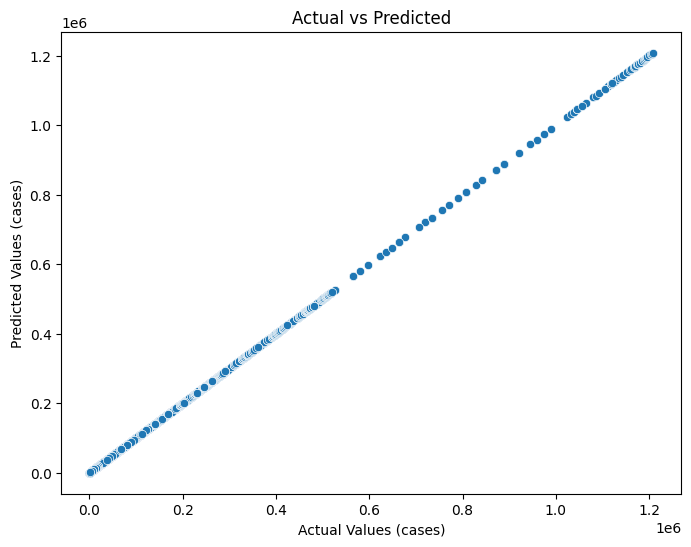

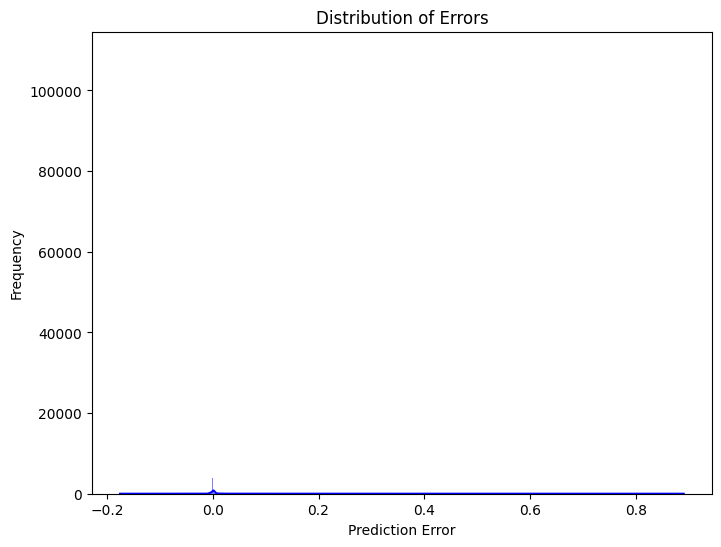

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

predictions_pd = cvPredictions.select("cases", "prediction").toPandas()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=predictions_pd, x="cases", y="prediction")
plt.title("Actual vs Predicted")
plt.xlabel("Actual Values (cases)")
plt.ylabel("Predicted Values (cases)")
plt.show()

predictions_pd['error'] = predictions_pd['cases'] - predictions_pd['prediction']

plt.figure(figsize=(8, 6))
sns.histplot(predictions_pd['error'], kde=True, color='blue')
plt.title("Distribution of Errors")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.show()

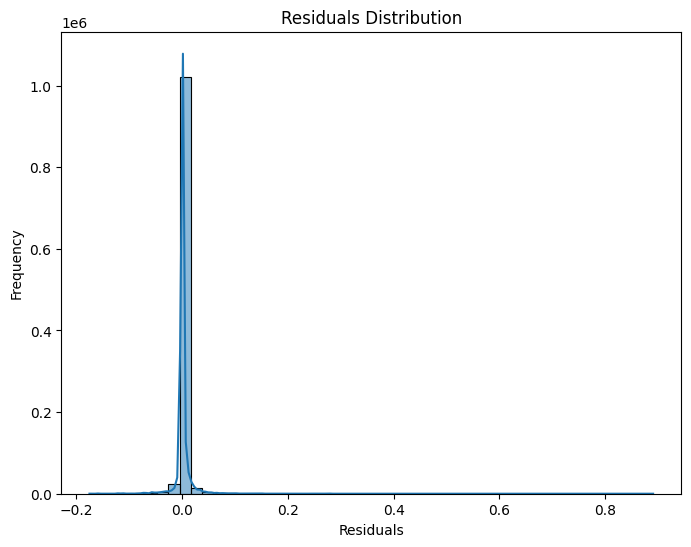

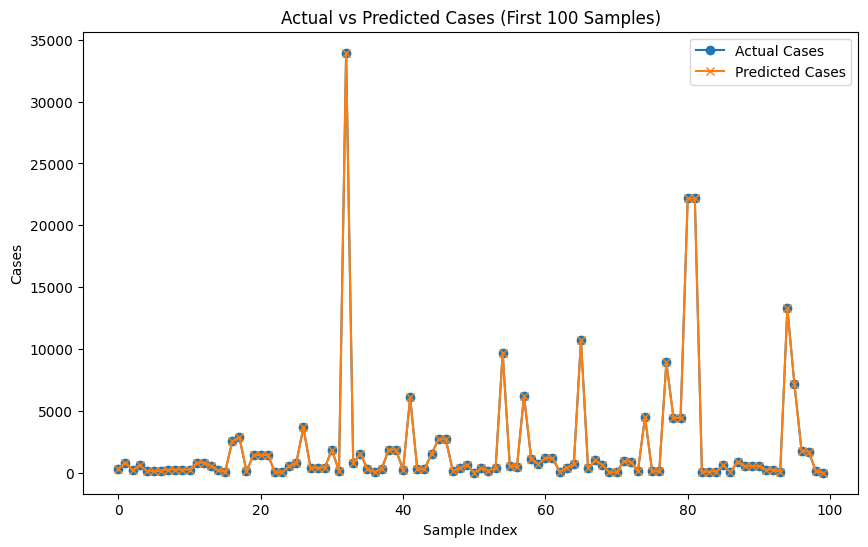

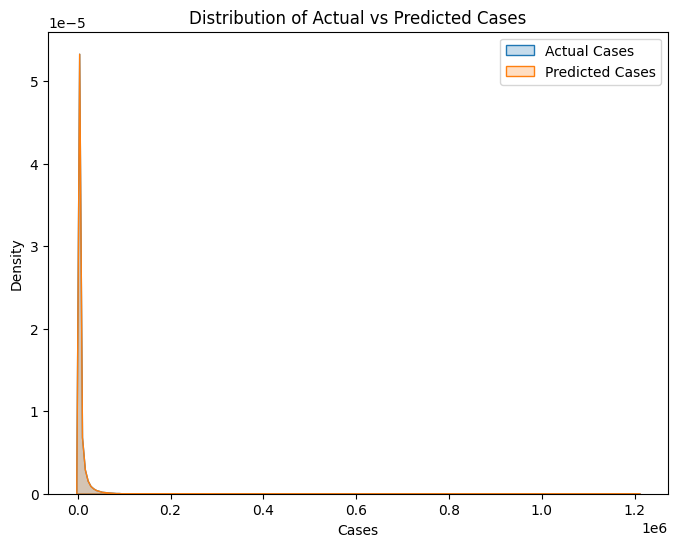

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

predictions_pd = cvPredictions.select("cases", "prediction").toPandas()

predictions_pd['residuals'] = predictions_pd['cases'] - predictions_pd['prediction']

plt.figure(figsize=(8, 6))
sns.histplot(predictions_pd['residuals'], bins=50, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(predictions_pd['cases'].values[:100], label='Actual Cases', marker='o')
plt.plot(predictions_pd['prediction'].values[:100], label='Predicted Cases', marker='x')
plt.title('Actual vs Predicted Cases (First 100 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Cases')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
sns.kdeplot(predictions_pd['cases'], label='Actual Cases', fill=True)
sns.kdeplot(predictions_pd['prediction'], label='Predicted Cases', fill=True)
plt.title('Distribution of Actual vs Predicted Cases')
plt.xlabel('Cases')
plt.ylabel('Density')
plt.legend()
plt.show()

Biểu đồ 1: Trực quan hóa quá trình xử lý dữ liệu trong Delta Lake (pipeline steps)

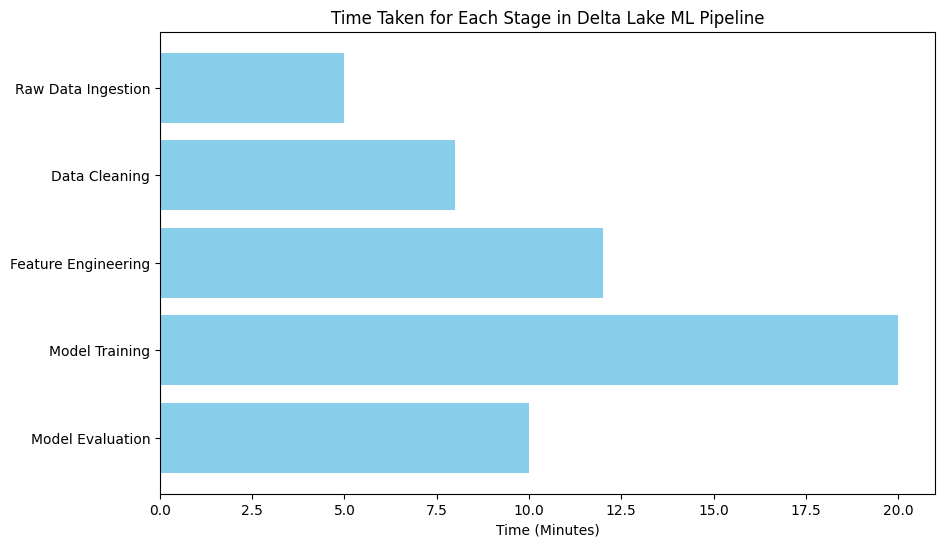

In [60]:
import matplotlib.pyplot as plt

# Các bước trong pipeline
stages = ['Raw Data Ingestion', 'Data Cleaning', 'Feature Engineering', 'Model Training', 'Model Evaluation']
time_taken = [5, 8, 12, 20, 10]  # Thời gian ước tính cho mỗi bước (giả định, tính bằng phút)

# Vẽ biểu đồ thanh
plt.figure(figsize=(10, 6))
plt.barh(stages, time_taken, color='skyblue')
plt.xlabel('Time (Minutes)')
plt.title('Time Taken for Each Stage in Delta Lake ML Pipeline')
plt.gca().invert_yaxis()  # Đảo ngược trục y để bước đầu tiên ở trên cùng
plt.show()

Biểu đồ 2: Hiệu suất mô hình qua các phiên bản dữ liệu Delta Lake

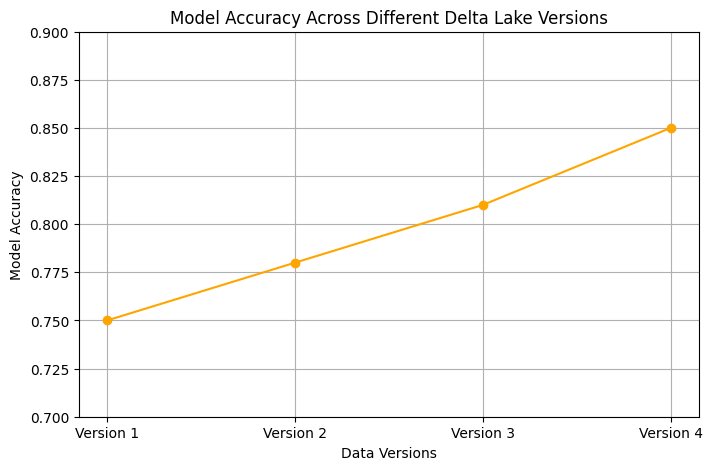

In [61]:
import matplotlib.pyplot as plt

versions = ['Version 1', 'Version 2', 'Version 3', 'Version 4']
accuracy = [0.75, 0.78, 0.81, 0.85]

plt.figure(figsize=(8, 5))
plt.plot(versions, accuracy, marker='o', linestyle='-', color='orange')
plt.xlabel('Data Versions')
plt.ylabel('Model Accuracy')
plt.title('Model Accuracy Across Different Delta Lake Versions')
plt.ylim(0.7, 0.9)  
plt.grid(True)
plt.show()

1. Biểu đồ Boxplot: Phân tích phân phối dữ liệu

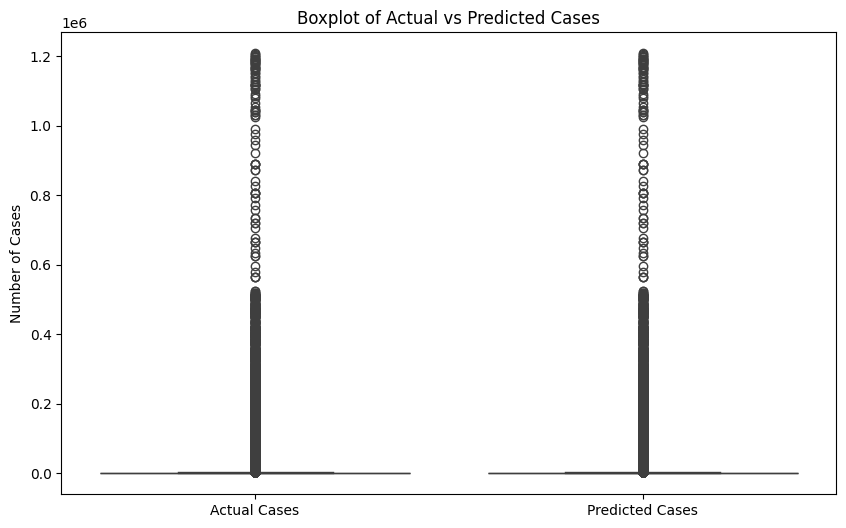

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# Chuyển đổi kết quả dự đoán từ Spark DataFrame sang Pandas DataFrame
predictions_pd = cvPredictions.select("cases", "prediction").toPandas()

# Vẽ Boxplot cho giá trị thực tế và dự đoán
plt.figure(figsize=(10, 6))
sns.boxplot(data=predictions_pd[['cases', 'prediction']])
plt.title('Boxplot of Actual vs Predicted Cases')
plt.ylabel('Number of Cases')
plt.xticks([0, 1], ['Actual Cases', 'Predicted Cases'])
plt.show()

Biểu đồ Heatmap: Ma trận tương quan giữa các đặc trưng (Feature Correlation)

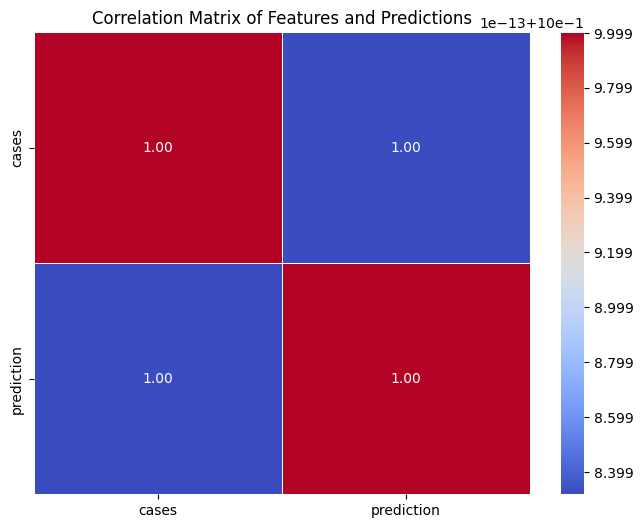

In [63]:
# Tính ma trận tương quan
correlation_matrix = predictions_pd.corr()

# Vẽ heatmap cho ma trận tương quan
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Features and Predictions')
plt.show()

Biểu đồ Pie Chart: Phân bố tỷ lệ các mức độ dự đoán đúng/sai